<a href="https://colab.research.google.com/github/oreomcflurryyy/statistical-learning-deeplearning/blob/main/deeplearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ISLP
!pip install pytorch-lightning
!pip install torchmetrics
!pip install torchvision
!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=80d5856acf6ea92740355fea5d2278d39bc4d6d7489e058081c14f4865bacbf4
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting u

In [ ]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

In [ ]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

INFO:lightning_fabric.utilities.seed:Seed set to 0


In [ ]:
from glob import glob
import json

In [125]:
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table

Fit a neural network to the Default data. Use a single hidden layer with 10 units, and dropout regularization. Compare the classification performance of your model with that of linear logistic regression.

### Neural Network

In [ ]:
Default = load_data('Default').dropna()
n = Default.shape[0]
Default = pd.get_dummies(Default, columns=['student'], drop_first=True)
Default['default'] = (Default['default'] == 'Yes').astype(int)

In [ ]:
Default

,default,balance,income,student_Yes
0,0,729.526495,44361.625074,False
1,0,817.180407,12106.134700,True
2,0,1073.549164,31767.138947,False
3,0,529.250605,35704.493935,False
4,0,785.655883,38463.495879,False
...,...,...,...,...
9995,0,711.555020,52992.378914,False
9996,0,757.962918,19660.721768,False
9997,0,845.411989,58636.156984,False
9998,0,1569.009053,36669.112365,False


In [ ]:
model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default).to_numpy()
Y = Default['default'].to_numpy()

In [ ]:
(X_train,
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

In [97]:
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),  # Single hidden layer with 10 units
            nn.ReLU(),  # Adding ReLU activation after first layer
            nn.Dropout(0.5),  # Dropout regularization
            nn.Linear(10, 1),  # Output layer
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        return self.sequential(x).squeeze(1)

In [98]:
def_model = DefaultModel(X.shape[1])

In [99]:
summary(def_model,
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [6666, 3]                 [6666]                    --
├─Sequential: 1-1                        [6666, 3]                 [6666, 1]                 --
│    └─Linear: 2-1                       [6666, 3]                 [6666, 10]                40
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 1]                 11
│    └─Sigmoid: 2-5                      [6666, 1]                 [6666, 1]                 --
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (M): 0.34
Input size (MB): 0.08
Forward/backward pass size (MB): 0.59
Params size (MB): 0.00
Estimated Total Size (MB): 0.67

In [100]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
def_train = TensorDataset(X_train_t, Y_train_t)

In [101]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
def_test = TensorDataset(X_test_t, Y_test_t)

In [102]:
max_num_workers = rec_num_workers()

In [103]:
def_dm = SimpleDataModule(def_train,
                          def_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=0.2)

In [104]:
def_module = SimpleModule.binary_classification(def_model)

In [105]:
def_logger = CSVLogger('logs', name='default')

In [107]:
def_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=def_logger,
                      callbacks=[ErrorTracker()])
def_trainer.fit(def_module, datamodule=def_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/default/version_7/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | DefaultModel      | 51     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [109]:
def_results = pd.read_csv(def_logger.experiment.metrics_file_path)
def_results

,epoch,step,test_accuracy,test_loss,train_accuracy_epoch,train_accuracy_step,train_loss,valid_accuracy,valid_loss
0,0,4,NaN,NaN,NaN,0.031250,NaN,NaN,NaN
1,0,9,NaN,NaN,NaN,0.031250,NaN,NaN,NaN
2,0,14,NaN,NaN,NaN,0.031250,NaN,NaN,NaN
3,0,19,NaN,NaN,NaN,0.156250,NaN,NaN,NaN
4,0,24,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1838,49,8344,NaN,NaN,NaN,0.906250,NaN,NaN,NaN
1839,49,8349,NaN,NaN,NaN,0.952381,NaN,NaN,NaN
1840,49,8349,NaN,NaN,NaN,NaN,NaN,0.968492,0.693147
1841,49,8349,NaN,NaN,0.842678,NaN,0.769306,NaN,NaN


In [110]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

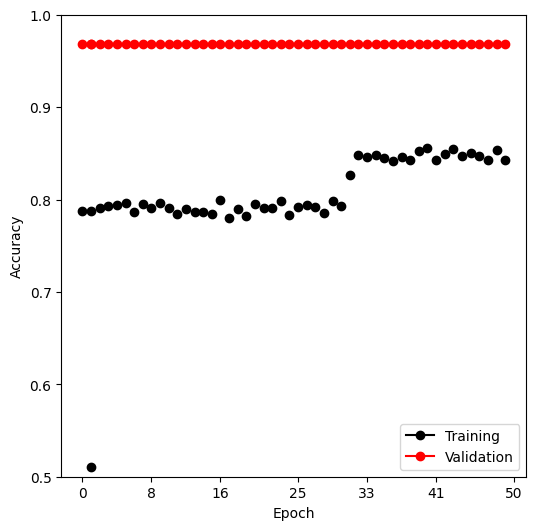

In [113]:
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(def_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 50, 7).astype(int));

In [108]:
def_trainer.test(def_module, datamodule=def_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.970005989074707     │
│         test_loss         │    0.6931472420692444     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6931472420692444, 'test_accuracy': 0.970005989074707}]

### Linear Logistic Regression

In [115]:
model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default)
Y = Default['default']

In [116]:
(X_train,
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

In [119]:
X_train = model.fit_transform(X_train)
glm = sm.GLM(Y_train,
             X_train,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
balance,0.0028,0.000000,18.633,0.0
income,-0.0002,0.000006,-27.814,0.0
student_Yes,-3.8195,0.185000,-20.665,0.0


In [120]:
X_test = model.transform(X_test)
probs = results.predict(exog=X_test)
np.array(probs[:10])

array([0.01672219, 0.00250404, 0.02165963, 0.01527177, 0.1209303 ,
       0.12306373, 0.00095922, 0.00291002, 0.00399638, 0.00132339])

In [126]:
labels = np.where(probs > 0.5, 1, 0)
confusion_table(labels, Y_test)

Truth,0,1
Predicted,,
0,3205,90
1,29,10


In [127]:
np.mean(labels == Y_test)

0.9643071385722856

### Model Performance Comparison
- Neural Network Accuracy: 97.00%
- Logistic Regression Accuracy: 96.43%

**Practical Implications**:
   - For this specific dataset, linear logistic regression might be the more practical choice due to:
     * Similar performance
     * Lower complexity
     * Better interpretability
     * Easier deployment